# Evaluation Exercise for "Machine Learning in Julia for Calorimeter Showers"

Submission by N. V. Karthik (https://github.com/NV-Karthik)

## 1. Preliminary Checks and Imports

Checking the environment to ensure correct Project.toml/Manifest.toml files are being tied to the notebook.

In [1]:
# check the virtual environment the notebook is running
println(Base.active_project())

D:\Projects\gsoc_hsf\evaluation\eval\Project.toml


Here to enable GPU compute I am using CUDA (which now comes with CuArrays and cuDNN packages inbuilt) 

In [2]:
# to import datasets
using CSV  
using DataFrames

# train neural networks
using Flux  
using CUDA   # enable GPU compute
using Statistics  # get statistics

# miscellaneous
using Random, ProgressMeter  

# for results and accuracy-scores
using Plots
using EvalMetrics

In [3]:
# check GPU backend

println("is GPU functional -", CUDA.functional())
println("GPU Backend -",Flux.GPU_BACKEND)

is GPU functional -true
GPU Backend -CUDA


## Function definitions

1. ```trainTestSplit```:Custom function is written to perform train-test split directly on dataframes, solely to avoid unnecessary juggling between datatypes that is demanded by some utility-function.

- It makes use of ```Random.shuffle``` method to randomly split it according to the ratio
- It returns <b>copies</b> of dataframe <b>views</b> which can be treated as seperate dataframes

2. ```normalizeData``` to normalize datasets

3. ```printAccuracies```: prints Confusion Matrix, Balanced Accuracy, F1 score, Precision, Recall, Accuracy given target and prediction arrays

4. ```plotConfusionMatrix```: plots confusion matrix given target and prediction arrays

In [4]:
function trainTestSplit(df, train_ratio)
    # check if train_ratio is out of bounds
    @assert 0 <= train_ratio <= 1 "train ratio should be between 0 and 1"
    
    # get row indices and shuffle them in-place
    indices = collect(axes(df, 1)) #
    shuffle!(indices)
    
    train_ids = indices .<= (nrow(df) .* train_ratio)
    
    # create train and test dataframes
    train_df = copy(view(df, train_ids, :))
    test_df = copy(view(df, .!train_ids, :))
    
    return train_df, test_df 
end

trainTestSplit (generic function with 1 method)

In [5]:
function normalizeData(X)
    mu = mean(X,dims=1)
    sigma = std(X,dims=1)
    
    X_norm = (X .- mu) ./ sigma
    
    return X_norm
end

normalizeData (generic function with 1 method)

In [6]:
function printAccuracies(actuals, predicts)

    # Calculate balanced accuracy
    bal_accuracy = balanced_accuracy(actuals, predicts)

    # Calculate F1 score
    f1 = f1_score(actuals, predicts)

    # Calculate precision
    precision_score = precision(actuals, predicts)

    # Calculate recall
    recall_score = recall(actuals, predicts)

    # Calculate accuracy
    accuracy_score = accuracy(actuals, predicts)

    # Print the results
    println("Balanced Accuracy: ", round(bal_accuracy, digits=3))
    println("F1 Score: ", round(f1, digits=3))
    println("Precision: ", round(precision_score, digits=3))
    println("Recall: ", round(recall_score, digits=3))
    println("Accuracy: ", round(accuracy_score, digits=3))
end

printAccuracies (generic function with 1 method)

In [7]:
function plotConfusionMatrix(actuals, predicts)
    # Compute confusion matrix
    cm = EvalMetrics.ConfusionMatrix(actuals, predicts)
    matrix_data = [cm.tp cm.fp ; 
                   cm.fn cm.tn]

    # Plot confusion matrix
    heatmap(matrix_data, aspect_ratio=:equal, xlabel="True Label", ylabel="Predicted Label", 
        xticks=([1, 2], ["s", "b"]), yticks=([1, 2], ["s", "b"]), color=:viridis, title="Confusion Matrix", 
        titlefontsize=12, grid=false, yflip=true)

    # Annotate each square with the corresponding count
    for (i, true_label) in enumerate(0:1)
        for (j, pred_label) in enumerate(0:1)
            count = matrix_data[i, j]
            annotate!([(j, i, text(string(count), 12, :white))])
        end
    end

    plot!()
end

plotConfusionMatrix (generic function with 1 method)

## 2. Importing Datasets and Statistical overview

- ```CSV``` is used to import dataset as a dataframe, which is then split into train-test sets
- validation set can also be extracted using the above function, but it is not in the scope of the assignment. Test is also auxillary considering that the assignment requires accuracy over the whole dataset

In [8]:
# extract dataset
data = CSV.read("./dataset.csv", DataFrame, header=1, delim=",")

# check dataset for any NaNs
nan_values = any(ismissing.(eachcol(data)))

if nan_values
    println("DataFrame contains NaN values.")
else
    println("DataFrame does not contain NaN values.")
end

DataFrame does not contain NaN values.


In [9]:
# train-test split
train, test = trainTestSplit(data, 0.7)

# seperating feature arrays and target arrays
Xtrain = permutedims(Matrix(train[:, 1:3]));
ytrain = Array(train[:, 4]);
Xtest = permutedims(Matrix(test[:, 1:3]));
ytest = Array(test[:, 4]);

# feature and target separation for whole dataset
X = permutedims(Matrix(data[:, 1:3]));
y = Array(data[:, 4]);

<b>From the below data we can see that the data set is looks normalised but is skewed. So no further normalization is required</b>

In [10]:
# check mean, variance and normalization of dataset

pos_x = Array(data[:, 1])
pos_y = Array(data[:, 2])
pos_z = Array(data[:, 3])

println("For pos_x: Mean:$(mean(pos_x)), Standard Deviation:$(std(pos_x)), Min:$(minimum(pos_x)), Max:$(maximum(pos_x))")
println("For pos_y: Mean:$(mean(pos_y)), Standard Deviation:$(std(pos_y)), Min:$(minimum(pos_y)), Max:$(maximum(pos_y))")
println("For pos_z: Mean:$(mean(pos_z)), Standard Deviation:$(std(pos_z)), Min:$(minimum(pos_z)), Max:$(maximum(pos_z))")
println("For class: Number of signals: $(sum(y .== "s")), Number of backgrounds: $(100000-sum(y .== "s"))")

For pos_x: Mean:0.49837172667218743, Standard Deviation:0.2890195887958162, Min:8.135429005351469e-6, Max:0.9999867758107679
For pos_y: Mean:0.5007244644148588, Standard Deviation:0.28894926978187585, Min:5.511745166275617e-6, Max:0.9999993497880489
For pos_z: Mean:0.5013030543388736, Standard Deviation:0.2886047210399743, Min:2.9884223970988444e-6, Max:0.9999704530580031
For class: Number of signals: 22445, Number of backgrounds: 77555


<b>uncomment the cell below and run it to visualise the dataset in 3d. But also note that doing so can slow down the jupyter notebook</b>

In [11]:
# visualize dataset

# plot3d = Plots.plot(pos_x,pos_y, pos_z, seriestype=:scatter, markersize = 1, group=y, legend=true)
# display(plot3d)

## 3. Defining and Training the Neural Network Model 

### Model Parameter/Hyper Parameter Choices

- The simplest neural network which I started with gave good enough accuracies with the test-set and whole data set. So I refrained to add further complications considering the higher compute power required for little more accuracy
- The Input ```Dense``` layer consists of 3 neurons for the 3 features in dataset, which moves into 10 units in the hidden layer. The final layer has 2 units each for the each desired output.
- Since the feature array size is low and the features are independent of each other (x, y, z coordinates), the simplest network must be chosen to avoid overfitting.
- Thus 1 hidden layer with sigmoid activation is chosen as sigmoid the most used activation for logistic regression
- <b>Sigmoid</b> activation is used for output layer as it is preferred for binary classification and its advantages of giving results open to probabilistic interpretation. Softmax can be used for multiclass classification.
- <b>Binary Cross-Entropy</b> loss function is preferred with sigmoid for binary classification, thus making its choice obvious. 
- <b>Adam</b> Optimizer is used with a moderate 0.01 learning rate due to its popularity with neural networks. Learning momenta are left to their default values

 
<br> </br>
Note: Additional <b>Batch Normalization</b> layer with <b>relu</b> activation is also tried on the network for two reasons,
1. as the data is not normalized 
2. and due to its proven effects on accuracy and training speed.   
Relu is chosen due as it can introduce a subtle non-linear activation which is required here.

And defying expectations Batch normalised data performs slightly worse than the non-Batch normalised model on the test set. (95% vs 98% accuracy).  
Also Batch-normed model also takes significantly more time to train (~25 min for non Batch normalised vs ~ 35min for Batch normalised) and raises errors with cuDNN to evaluate larger input arrays (eg. test set with 30000 rows will work but the whole dataset will overflow gpu memory),
Hence a model without batch normalization is used here.

Nevertheless batch normed model can be tried by uncommenting the ```BatchNorm(10, relu),``` line below

In [12]:
# Define the neural network model

model = Chain(
    Dense(3=>10, σ, bias=true),  # Input layer with 3 neurons, hidden layer with 64 neurons
#     BatchNorm(10, relu),
    Dense(10=>2),      # Output layer with 2 neurons (for binary classification)
    σ            # sigma activation function for binary classification
    ) |> gpu  # Move model to gpu if available

Chain(
  Dense(3 => 10, σ),                    # 40 parameters
  Dense(10 => 2),                       # 22 parameters
  NNlib.σ,
)                   # Total: 4 arrays, 62 parameters, 680 bytes.

In [13]:
# Define loss function and optimizer

loss_func = Flux.binarycrossentropy
optim = Flux.setup(Flux.Adam(0.01), model);

## Dataloading
- target arrays are one-hot encoded for performance reasons
- batch size of input features is taken as 64 not too big or not too small, to account for both memory and statistical sampling constraints

In [14]:
# data loading
ytrain_onehot = Flux.onehotbatch(ytrain, ["s", "b"]);
loader = Flux.DataLoader((Xtrain, ytrain_onehot) |> gpu, batchsize=64, shuffle=true)

1094-element DataLoader(::Tuple{CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}, OneHotArrays.OneHotMatrix{UInt32, CuArray{UInt32, 1, CUDA.Mem.DeviceBuffer}}}, shuffle=true, batchsize=64)
  with first element:
  (3×64 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}, 2×64 OneHotMatrix(::CuArray{UInt32, 1, CUDA.Mem.DeviceBuffer}) with eltype Bool,)

## Training

Generic training loop is presented with 1000 epochs (which was decided from the loss vs epochs plot shown further below)

In [15]:
# Training loop, using the whole data set 1000 times:
losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            loss_func(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:31:34mm


# 4. Model Evaluation

Firstly predictions on the test set are evaluated, and its accuracy is obtained to be <b>98.6%</b>

In [16]:
# predictions on the test set

y_pred = model(Xtest |> gpu) |> cpu

# getting the test set accuracy

y_actual = Array(ytest .== "s")
test_predicts = Array(y_pred[1,:] .> 0.5)
test_acc = mean( test_predicts .== y_actual) * 100

98.44000000000001

Then predictions on the whole dataset is evaluated, its accuracy can be seen as <b>96.8%</b>

In [17]:
# accuracy over the whole dataset

y_pred_total = model(X |> gpu) |> cpu

y_actual_total = Array(y .== "s")
total_predicts = (y_pred_total[1,:] .> 0.5)

total_acc = mean(total_predicts .== y_actual_total) * 100

98.421

## More Evaluation Metrics on the Test set

model's

- Confusion Matrix
- Balanced Accuracy (necessary for skewed datasets like this one)
- F1 score
- Precision
- Recall
- Accuracy

are included as a model's standard performance metrics  


(from stdout)  
Balanced Accuracy: 0.982  
F1 Score: 0.97  
Precision: 0.966  
Recall: 0.974  
Accuracy: 0.986

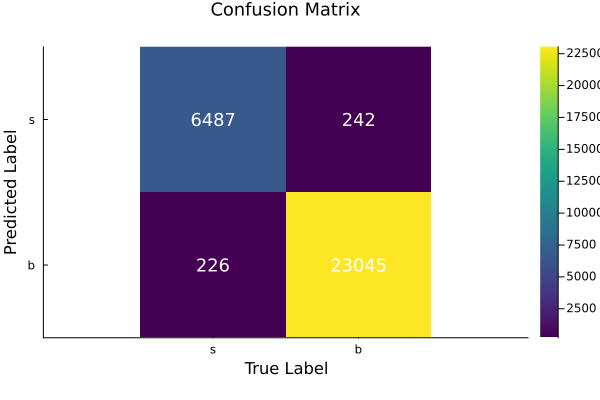

In [18]:
plotConfusionMatrix(y_actual, test_predicts)

In [19]:
printAccuracies(y_actual, test_predicts)

Balanced Accuracy: 0.978
F1 Score: 0.965
Precision: 0.964
Recall: 0.966
Accuracy: 0.984


## More Evaluation Metrics of model on the Whole dataset

same metrics are presented here as well  


(from stdout)  
Balanced Accuracy: 0.98  
F1 Score: 0.967  
Precision: 0.963  
Recall: 0.971  
Accuracy: 0.985


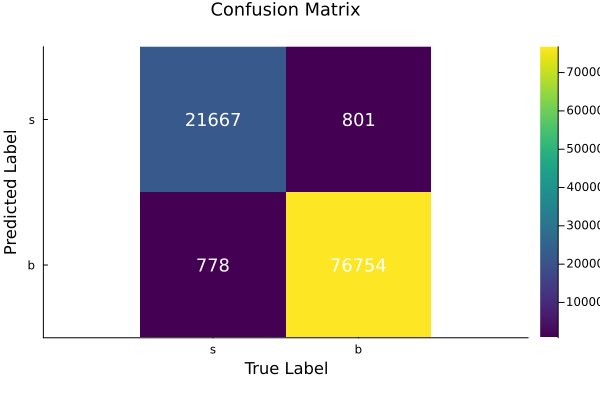

In [20]:
plotConfusionMatrix(y_actual_total, total_predicts)

In [21]:
printAccuracies(y_actual_total, total_predicts)

Balanced Accuracy: 0.978
F1 Score: 0.965
Precision: 0.964
Recall: 0.965
Accuracy: 0.984


## Loss variation as Training progresses

<b>uncomment the cell below and run it to visualise the dataset in 3d. But also note that doing so can slow down the jupyter notebook</b>  

or you can refer to the loss_curve.png for the same figure

In [22]:
# plot(losses; xaxis=(:log10, "iteration"),
#     yaxis="loss", label="per batch")
# n = length(loader)
# plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
#     label="epoch mean")
# # savefig("loss_curve.png")